In [1]:
# Prepare graph data...
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import namedtuple
Graph = namedtuple('Graph', ['X', 'Ri', 'Ro', 'y'])
class GraphDataset():
    def __init__(self, input_dir, n_samples=None):
        input_dir = os.path.expandvars(input_dir)
        filenames = [os.path.join(input_dir, f) for f in os.listdir(input_dir)
                     if f.startswith('event') and f.endswith('.npz')]
        self.filenames = (
            filenames[:n_samples] if n_samples is not None else filenames)

    def __getitem__(self, index):
        return load_graph(self.filenames[index])

    def __len__(self):
        return len(self.filenames)
def get_dataset(input_dir,n_files):
    return GraphDataset(input_dir, n_files)
def load_graph(filename):
    graph_dir = os.path.join(os.getcwd(), 'graphs')
    # Construct the full path to the specified file
    full_path = os.path.join(graph_dir, filename)
    """Read a single graph NPZ"""
    with np.load(full_path) as f:
        return sparse_to_graph(**dict(f.items()))
def sparse_to_graph(X, Ri_rows, Ri_cols, Ro_rows, Ro_cols, y, dtype=np.float32):
    n_nodes, n_edges = X.shape[0], Ri_rows.shape[0]
    Ri = np.zeros((n_nodes, n_edges), dtype=dtype)
    Ro = np.zeros((n_nodes, n_edges), dtype=dtype)
    Ri[Ri_rows, Ri_cols] = 1
    Ro[Ro_rows, Ro_cols] = 1
    return Graph(X, Ri, Ro, y)
#Function to load X, Ri, Ro, Y.
def load_raw(graph_name,xyr):
    graph_ex=load_graph(graph_name)
    #Load raw data
    y=graph_ex.y
    Ri=graph_ex.Ri
    Ro=graph_ex.Ro
    X=graph_ex.X
    if xyr=='X':
        return X
    elif xyr=='Ri':
        return Ri
    elif xyr=='Ro':
        return Ro
    else:
        return y

In [62]:
# Load X data of dimension Nv x 4(including color)
import os
import pandas as pd
dir_ = os.path.join(os.getcwd(), 'color')
#dir_ = os.path.join(os.getcwd(), 'coloredX')
file_path = os.path.join(dir_, "event000001000_g000.csv")
colorX = pd.read_csv(file_path)
print("features data loaded...")

features data loaded...


In [3]:
#Convenient representation of edge data 
#edges = [[i1,j1], [i2,j2], ... ]; i1, i2,... are outgoing-nodes, and j1, j2, ... are incoming-nodes
import json
graph='event000001000_g000'
with open("./networks/"+graph+".json", "r") as json_file:
        _,_,edges= json.load(json_file)
print("edge data loaded...")

edge data loaded...


In [115]:
# Prepare data for training (quantum circuits and labels)
y = load_raw('event000001000_g000.npz','y')
#Define Ys
Ys = []
Ys_01 = []
#Number of training samples
n_samples=10
#Regularization for binary loss
epsilon=0.01
#Number of vertices in each sample
cut=4
for i in range(n_samples):
    Y = np.array(y[cut*i:cut*(i+1)])  # True edge labels of dimension
    Ys_01.append(y[cut*i:cut*(i+1)])
    #Need to regularize Y to prevent Log(0) in loss function
    for i in range(len(Y)):
        if Y[i]==0:
            Y[i]+=epsilon
        else:
            Y[i]-=epsilon
    Ys.append(Y)
print("Ys prepared...")

Ys prepared...


In [ ]:
#Vertices for each edge
graph_ex=load_graph('event000001000_g000.npz')
#Load raw data
Ri=graph_ex.Ri
Ro=graph_ex.Ro
Ri,Ro = Ri.T, Ro.T
Rio=Ri+Ro
pairs = []
for j,row in enumerate(Rio):
    one_ind=[i for i,n in enumerate(row) if n==1]
    pairs.append(one_ind)

In [ ]:
import json
graph_name='event000001000_g000.npz'
print("Saving ",graph_name)
# Save the result to a JSON file
with open("./pairs/"+graph_name[:-4]+"_pairs.json", "w") as json_file:
    json.dump(pairs, json_file)

In [162]:
graph='event000001000_g000.npz'
with open("./networks/"+graph[:-4]+".json", "r") as json_file:
    node_pos,node_colors,edges= json.load(json_file)

In [215]:
y = load_raw('event000001000_g000.npz','y')
y

array([1., 0., 0., ..., 1., 1., 1.], dtype=float32)

In [203]:
pairs=[]
for row in Rio[:100]:
    pair=[]
    for i,n in enumerate(row):
        if n==1:
            pair.append(i)
    pairs.append(pair)
len(pairs)

100

In [ ]:
def draw_graph(graph):
    with open("./networks/"+graph[:-4]+".json", "r") as json_file:
        node_pos,node_colors,edges= json.load(json_file)
    # Create a 3D figure
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    # Define a discrete colormap based on the unique colors in your data
    unique_colors = set(node_colors)
    cmap = plt.get_cmap('tab10', len(unique_colors))  # 'tab10' is a predefined colormap
    # Map unique colors to integers for discrete colormap
    color_mapping = {color: i for i, color in enumerate(unique_colors)}
    node_colors_mapped = [color_mapping[color] for color in node_colors]
    print("Drawing nodes...")
    # Draw nodes with discrete colors
    for (node, pos), color in zip(node_pos.items(), node_colors_mapped):
        x, y, z = pos
        ax.scatter(x, y, z, c=[cmap(color)], s=20)  # Use the discrete colormap here
    print("Drawing edges...")
    # Draw edges (replace with your edge drawing logic)
    for u, v in edges:
        x1, y1, z1 = node_pos[u]
        x2, y2, z2 = node_pos[v]
        ax.plot([x1, x2], [y1, y2], [z1, z2], 'r-', linewidth=1.0)  # Customize edge appearance
    print("Showing the graph...")
    plt.show()

In [118]:
#Collect relevant vertices
vertices_set=[]
j=0
for i in range(n_samples):
    temp=[]
    while len(temp)<cut:
        s,e=pairs[j]
        if s not in temp: 
            temp.append(s)
        if e not in temp:
            temp.append(e)
        j+=1
    vertices_set.append(temp)
#Padding needed-- not all temp has equal length
mx_length=max([len(v) for v in vertices_set])
for vertices in vertices_set:
    if len(vertices)<mx_length:
        rand_n=0
        while rand_n in vertices:
            rand_n+=1
        vertices.append(rand_n)
#colored X data
Xs=[]
for vertices in vertices_set:
    raw_data=[]
    for v in vertices:
        raw_data.append(colorX.values[v])
    raw_data=np.array(raw_data)
    Xs.append(raw_data.flatten())    
print("Xs prepared...")

Xs prepared...


In [119]:
print("Xs shape ",len(Xs),len(Xs[0]))
print("Ys shape ",len(Ys),len(Ys[0]))

Xs shape  10 20
Ys shape  10 4


In [241]:
vertices_set[0]

[0, 1, 1488, 3050, 2]

In [242]:
pairs[:3]

[[0, 1], [0, 1488], [0, 3050]]

In [243]:
cut

4

In [246]:
y = load_raw('event000001000_g000.npz','y')
y[:4]

array([1., 0., 0., 0.], dtype=float32)

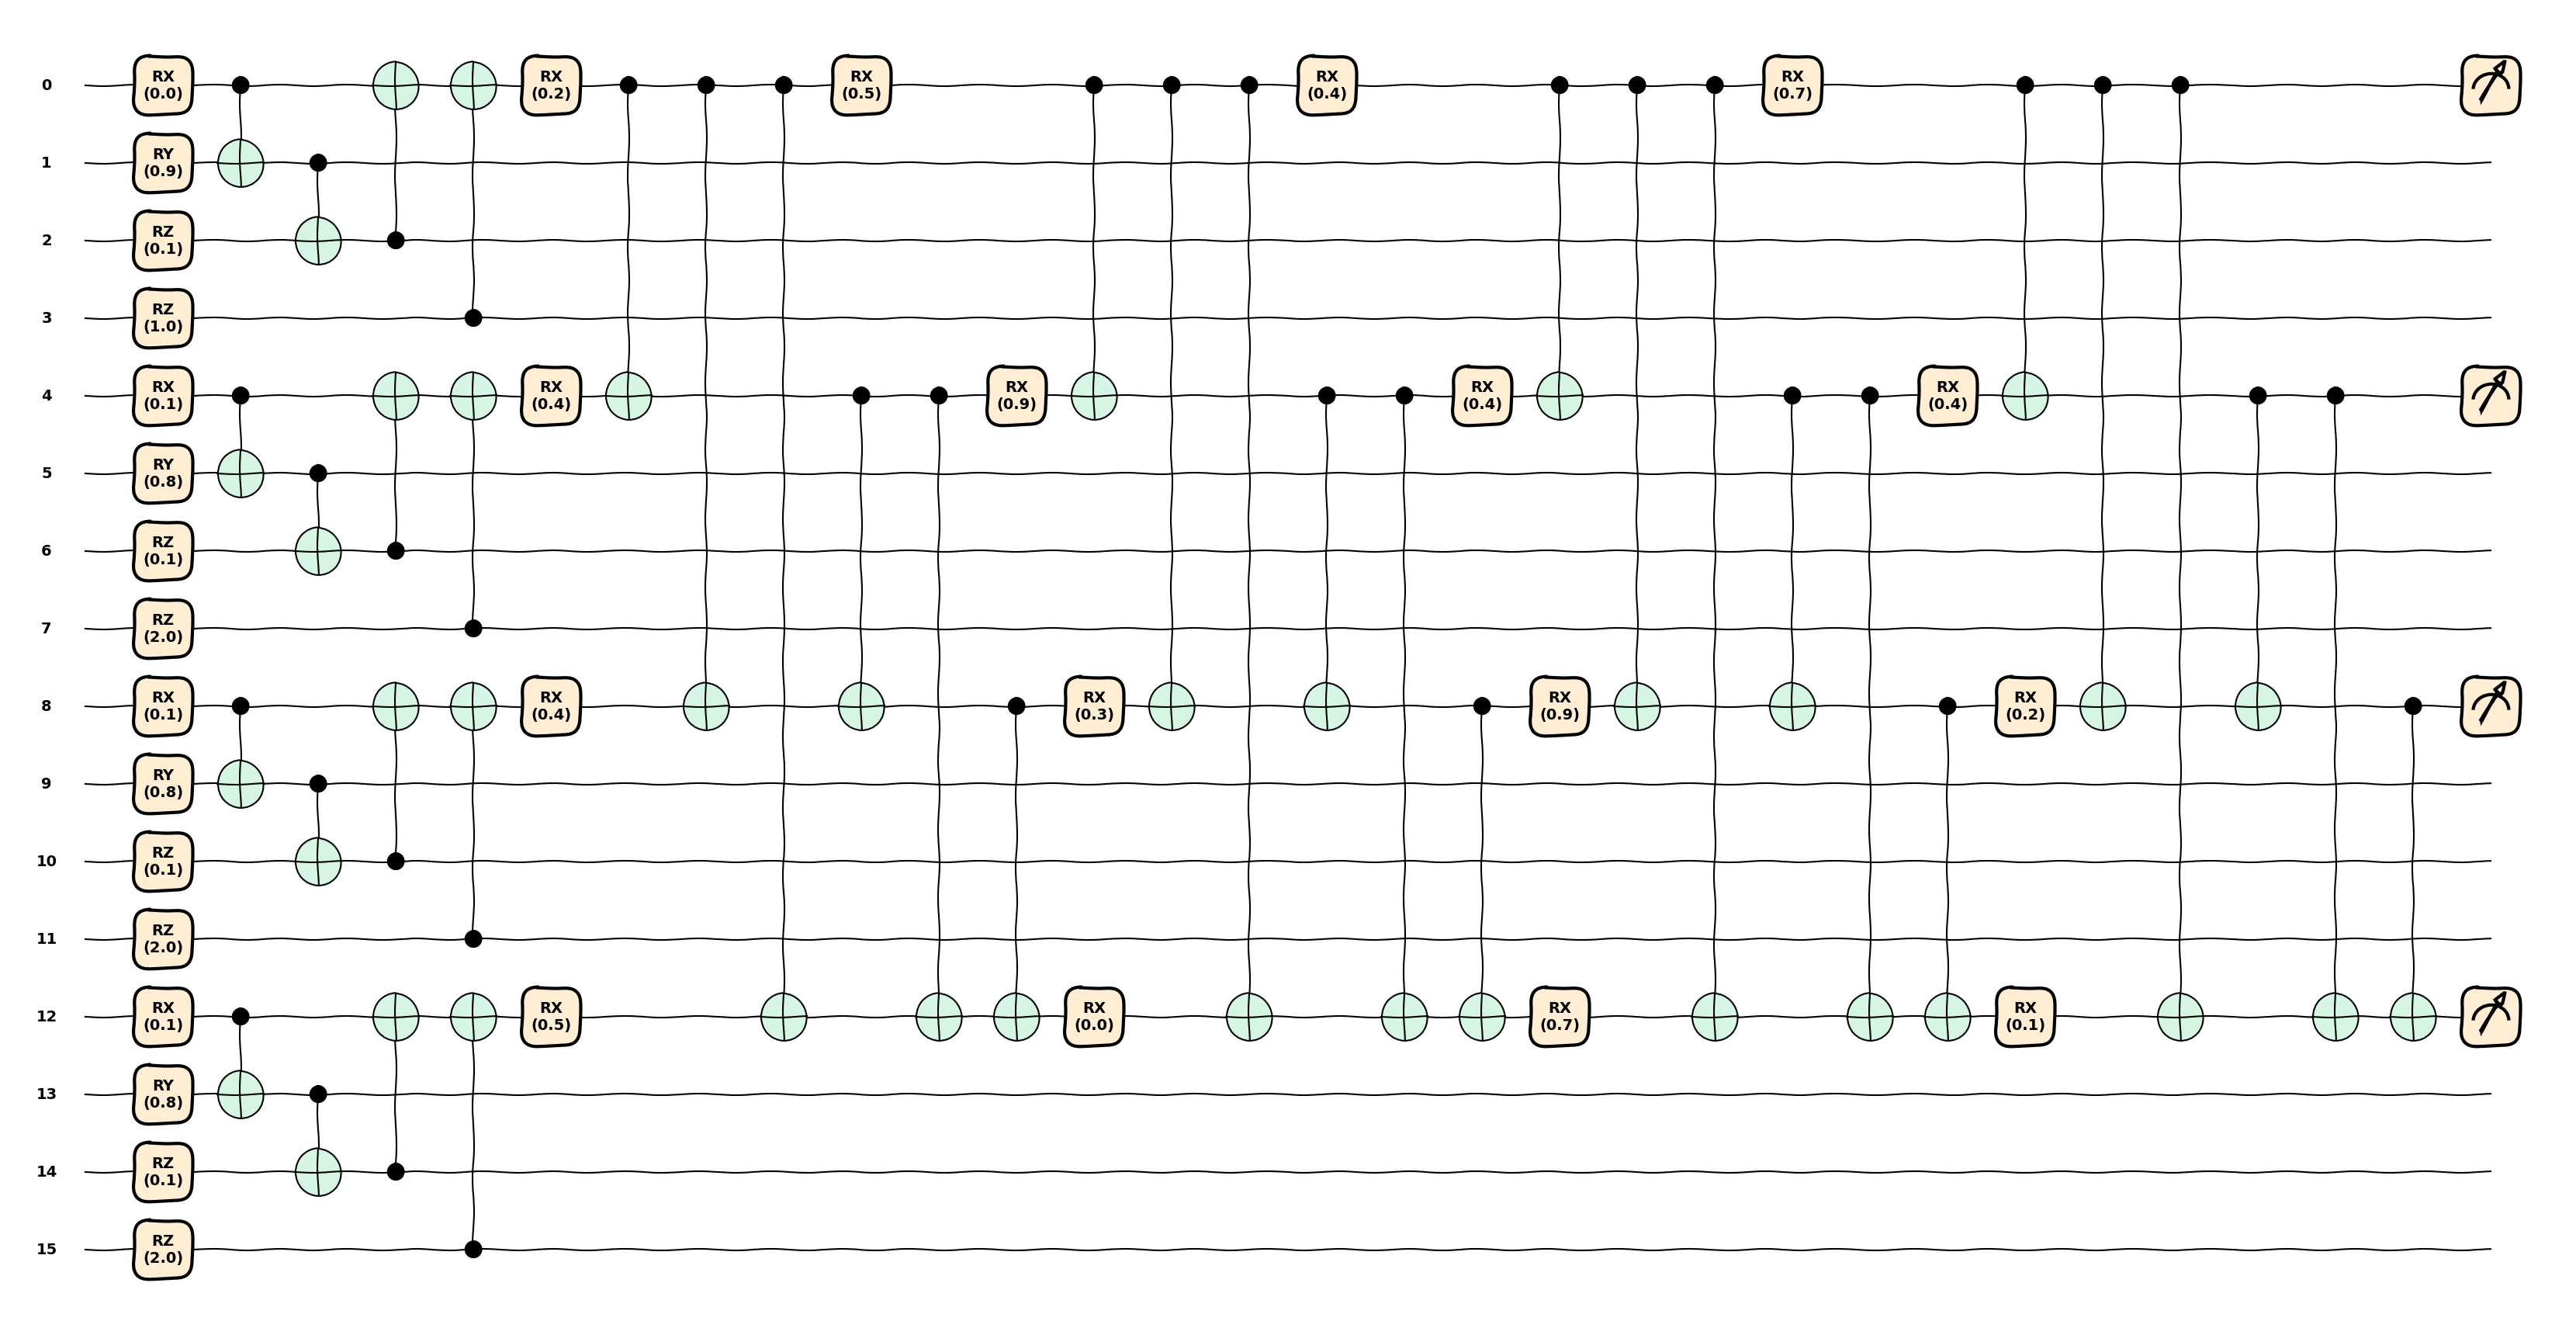

In [233]:
import pennylane as qml
from qiskit.circuit import Parameter
# Create a quantum circuit with Nv qubits
Nv = cut
num_qubits = Nv * 4  # 4 qubits per row (x,y,z,color)
# Define a list of trainable parameters for the entanglement
num_params = cut  # Number of trainable parameters for the entanglement
layers=4
Adj=[[0,1,0,0],[1,0,0,0],[0,0,0,0],[0,0,0,0]]
ansatz = np.random.random(size=(num_params*layers))
def quantum_circuit(X,ansatz):
    for i in range(Nv):
        for j in range(4):
            if j==0:
                qml.RX(X[i*4+j], wires = i * 4 + j)
            elif j==1:
                qml.RY(X[i*4+j], wires = i * 4 + j)
            else:
                qml.RZ(X[i*4+j], wires = i * 4 + j)
        #Entangle 3 positions
        qml.CNOT(wires = [i * 4, i * 4 + 1])
        qml.CNOT(wires = [i * 4 + 1, i * 4 + 2])
        qml.CNOT(wires = [i * 4 + 2, i * 4])
        #Entangle color and position-x.
        qml.CNOT(wires = [i * 4 + 3, i * 4])
    for l in range(layers):
        # Apply trainable gates
        for i in range(cut):
            qml.RX(ansatz[i+l*cut], wires = i * 4)
        #Fully connect
        for i in range(cut):
            for j in range(i + 1, cut):
                # Use trainable parameters for entanglement angles
                qml.CNOT(wires = [i * 4, j * 4])
    return [qml.expval(qml.PauliZ(i*4)) for i in range(Nv)]

dev = qml.device("default.qubit", wires=4*Nv)
qnode = qml.QNode(quantum_circuit, dev)
qml.draw_mpl(qnode, decimals=1, style="sketch")(Xs[0],ansatz)
plt.show()

In [250]:
vertices_set[0]

[0, 1, 1488, 3050, 2]

In [247]:
pairs[:3]

[[0, 1], [0, 1488], [0, 3050]]

In [251]:
# Initialize a measurement quantum circuit
def circuit(X, ansatz):
    dev = qml.device('default.qubit', wires=Nv*4)
    @qml.qnode(dev)
    def quantum_circuit(X,ansatz):
        for i in range(Nv):
            for j in range(4):
                if j==0:
                    qml.RX(X[i*4+j], wires = i * 4 + j)
                elif j==1:
                    qml.RY(X[i*4+j], wires = i * 4 + j)
                else:
                    qml.RZ(X[i*4+j], wires = i * 4 + j)
            #Entangle 3 positions
            qml.CNOT(wires = [i * 4, i * 4 + 1])
            qml.CNOT(wires = [i * 4 + 1, i * 4 + 2])
            qml.CNOT(wires = [i * 4 + 2, i * 4])
            #Entangle color and position-x.
            qml.CNOT(wires = [i * 4 + 3, i * 4])
        for l in range(layers):
            # Apply trainable gates
            for i in range(cut):
                qml.RX(ansatz[i+l*cut], wires = i * 4)
            #Fully connect
            for i in range(cut):
                for j in range(i + 1, cut):
                    # Use trainable parameters for entanglement angles
                    qml.CNOT(wires = [i * 4, j * 4])
        return [qml.expval(qml.PauliZ(i*4)) for i in range(Nv)]
    expectations = quantum_circuit(X, ansatz)
    return expectations
Adj=[[0,1,0,0],[1,0,1,0],[1,0,0,1],[0,0,1,0]]
#Binary entropy loss function
def binary(x,xp):
    new_x=[0 for _ in range(len(xp))]
    l=0
    for i in range(Nv):
        for j in range(i+1,Nv):
            if Adj[i][j]==1:
                new_x[l]=x[i]+x[j]
                l+=1
    res=[x[i]*np.log(1-xp[i])+(1-x[i])*np.log(xp[i])
        for i in range(len(x)-1)]
    return -(1/(len(x)-1))*sum(res)
def costfunc(params):
    cost = 0
    for i in range(n_samples):
        cost += binary(circuit(Xs[i], params),Ys[i])
    return cost/n_samples
from pennylane import numpy as np
#Initialize trainable parameters
ansatz = np.random.normal(0, 0.1, size=(num_params*layers), requires_grad=True)
#Set-up the optimizer
optimizer = qml.AdamOptimizer(stepsize=0.01)
previous_cost = float('inf')  # Set to a large initial value
# A small threshold to check for convergence
tolerance = 1e-4
#Training start
for k in range(30):
    cost=costfunc(ansatz)
    if k % 3 == 0:
        print(f"Step {k}, cost: {cost}")
    if abs(cost - previous_cost) < tolerance:
        print(f"Converged at step {k}, cost: {cost}")
        break
    ansatz = optimizer.step(costfunc, ansatz)
    previous_cost=cost

Step 0, cost: 1.9898148969786622
Step 3, cost: 1.9597927157708241
Step 6, cost: 1.9367988766111495
Step 9, cost: 1.919872522350282
Step 12, cost: 1.9083423139779714
Step 15, cost: 1.901374848517651
Step 18, cost: 1.8977119670648857
Step 21, cost: 1.896160096542593
Step 24, cost: 1.8952963577906352
Step 27, cost: 1.8940219531355247


In [252]:
#Measure with the fixed parameters
dev = qml.device('default.qubit', wires=Nv*4)
@qml.qnode(dev)
def measure(X,ansatz):
    expect = quantum_circuit(X,ansatz)
    return expect
def zeroOne(arr):
    return [1 if n>0.5 else 0 for n in arr]
for i in range(n_samples):
    result=measure(Xs[i],ansatz)
    print("Compare ",result,
          " with ",Ys_01[i])

Compare  [tensor(0.6592528, requires_grad=True), tensor(0.55295287, requires_grad=True), tensor(0.66293766, requires_grad=True), tensor(0.61074048, requires_grad=True)]  with  [1. 0. 0. 0.]
Compare  [tensor(0.6592528, requires_grad=True), tensor(0.54715086, requires_grad=True), tensor(0.65677403, requires_grad=True), tensor(0.61108029, requires_grad=True)]  with  [0. 0. 0. 1.]
Compare  [tensor(0.6592528, requires_grad=True), tensor(0.54680907, requires_grad=True), tensor(0.96921954, requires_grad=True), tensor(0.89727984, requires_grad=True)]  with  [0. 0. 0. 0.]
Compare  [tensor(0.97046385, requires_grad=True), tensor(0.810256, requires_grad=True), tensor(0.96918803, requires_grad=True), tensor(0.89624698, requires_grad=True)]  with  [1. 1. 0. 0.]
Compare  [tensor(0.97046385, requires_grad=True), tensor(0.81160298, requires_grad=True), tensor(0.93369254, requires_grad=True), tensor(0.86365223, requires_grad=True)]  with  [0. 1. 0. 0.]
Compare  [tensor(0.60821066, requires_grad=True), 

Use data reuploading
Use prior graph topology information